In [2]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from linearmodels import PooledOLS

In [53]:
sin_portfolio_df = pd.read_csv("sin_portfolio_returns.csv")

other_factors_df = pd.read_csv("final_merged.csv")

# Converting data types for merging

In [54]:
sin_portfolio_df["Date"] = pd.to_datetime(sin_portfolio_df["Date"])
sin_portfolio_df.set_index("Date", inplace=True)
sin_portfolio_df.head()

,Num_Active_Stocks,BEAM,BEER,PFB,ABW,GBL,RUP,CNB,CKB,FAL,...,DEO,RUM,VCO,ADSO,NDC,GWT,CEDC,PTT,Portfolio_Returns,Portfolio_Proportion
Date,,,,,,,,,,,,,,,,,,,,,
1962-08-31,19,NaN,NaN,0.005013,NaN,0.005263,0.000248,0.003096,NaN,-0.000405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030799,0.052632
1962-09-30,19,NaN,NaN,-0.002288,NaN,-0.009569,-0.002471,-0.002924,NaN,-0.003672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053395,0.052632
1962-10-31,19,NaN,NaN,-0.007177,NaN,-0.023392,-0.004148,0.003096,NaN,-0.002193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048491,0.052632
1962-11-30,17,NaN,NaN,NaN,NaN,NaN,0.001258,0.004085,NaN,0.004859,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082107,0.058824
1962-12-31,18,NaN,NaN,NaN,0.0,NaN,0.000873,0.002165,NaN,-0.001562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018254,0.055556


In [55]:
other_factors_df.rename(columns = {"Unnamed: 0": "Date", "Excess Return on the Market": "ExRm"}, inplace = True)
other_factors_df["Date"] = pd.to_datetime(other_factors_df["Date"])
other_factors_df.set_index("Date", inplace=True)
other_factors_df.head()

,ABEV,ABUD,ABV,ABW,ACCOB,ADC,ADSO,AED,AFTI,BACA,...,VO,FARM,GMCR,JVA,PEET,ExRm,SMB,HML,MOM,USREC
Date,,,,,,,,,,,,,,,,,,,,,
1962-07-31,NaN,NaN,NaN,NaN,NaN,37.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0628,0.0163,-0.0357,0.0055,0
1962-08-31,NaN,NaN,NaN,NaN,NaN,37.250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,NaN,NaN,NaN,NaN,NaN,37.250,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,NaN,NaN,NaN,NaN,NaN,33.375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,NaN,NaN,NaN,2.5,NaN,39.625,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.1087,0.0259,0.0099,-0.0717,0


# Filtering required columns only

In [56]:
sin_portfolio_df = sin_portfolio_df[["Portfolio_Returns"]]
other_factors_df = other_factors_df[["ExRm", "SMB", "HML", "MOM", "USREC"]]


# Merging for model building

## Checking shapes before merging

In [57]:
sin_portfolio_df.shape, other_factors_df.shape

((701, 1), (702, 5))

In [58]:
model_df = pd.concat([sin_portfolio_df, other_factors_df], axis = 1, join = "inner")

model_df.rename(columns = {"Portfolio_Returns": "Portfolio_Excess_Return"}, inplace=True)
model_df

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-08-31,0.030799,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,-0.053395,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,-0.048491,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,0.082107,0.1087,0.0259,0.0099,-0.0717,0
1962-12-31,-0.018254,0.0101,-0.0380,0.0035,0.0588,0
...,...,...,...,...,...,...
2020-08-31,-0.018834,0.0763,-0.0022,-0.0293,0.0051,0
2020-09-30,0.026879,-0.0363,-0.0004,-0.0266,0.0305,0
2020-10-31,-0.030275,-0.0210,0.0439,0.0419,-0.0303,0


# Exploratory Data Analysis

<AxesSubplot:xlabel='Date'>

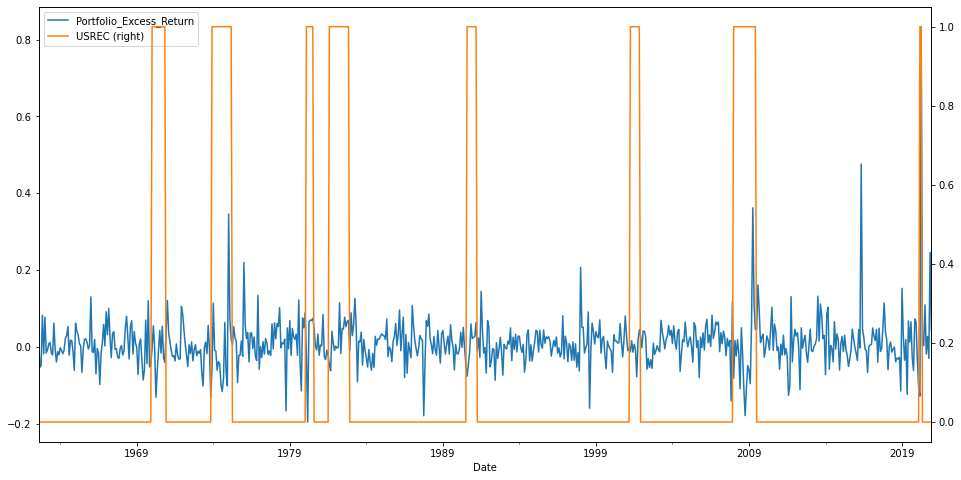

In [59]:
model_df[["Portfolio_Excess_Return", "USREC"]].plot(secondary_y = ["USREC"], figsize = (16,8))

We see abnormal spikes in the portfolio excess return. Upon closer inspection, there are INF values in sin portfolio returns

In [60]:
model_df[model_df["Portfolio_Excess_Return"] == np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


In [61]:
model_df[model_df["Portfolio_Excess_Return"] == -np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


## Replacing INF values with 0 (TEMPORARY FIX)

In [62]:
model_df.replace([np.inf, -np.inf], 0, inplace=True)

In [63]:
model_df[model_df["Portfolio_Excess_Return"] == np.inf]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


# Replotting

<AxesSubplot:xlabel='Date'>

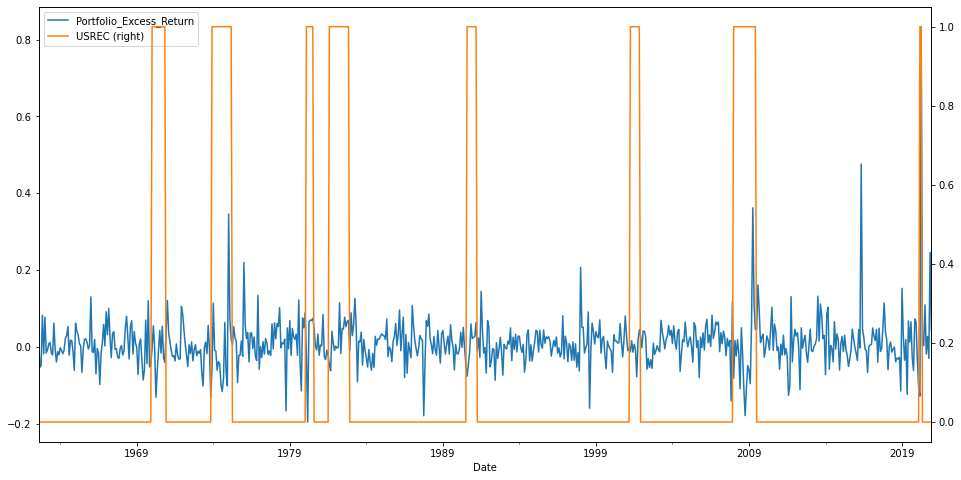

In [64]:
model_df[["Portfolio_Excess_Return", "USREC"]].plot(secondary_y = ["USREC"], figsize = (16,8))

In [65]:
model_df.describe()

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.008937,0.005855,0.001956,0.002618,0.006360,0.121255
std,0.064884,0.044649,0.030420,0.028446,0.041981,0.326657
min,-0.196050,-0.232400,-0.172900,-0.140200,-0.343900,0.000000
25%,-0.019225,-0.019600,-0.016500,-0.013700,-0.009100,0.000000
50%,0.005527,0.009300,0.001400,0.002700,0.007100,0.000000
75%,0.034454,0.034400,0.020300,0.016900,0.028900,0.000000
max,0.833630,0.161000,0.214800,0.124800,0.183600,1.000000


### Checking periods where Portfolio_Excess_Return > 100%

In [66]:
model_df[model_df["Portfolio_Excess_Return"] > 100]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,


Upon rechecking the price data, some stocks have extremely volatile price movements (e.g. STZ), resulting in extremely high jumps in portfolio returns

### Checking periods of negative Portfolio REturns

In [67]:
model_df[model_df["Portfolio_Excess_Return"] < 0]

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-09-30,-0.053395,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,-0.048491,-0.0005,-0.0401,0.0135,0.0075,0
1962-12-31,-0.018254,0.0101,-0.0380,0.0035,0.0588,0
1963-02-28,-0.016001,-0.0238,0.0046,0.0220,0.0252,0
1963-03-31,-0.008428,0.0308,-0.0248,0.0190,0.0156,0
...,...,...,...,...,...,...
2020-01-31,-0.033986,-0.0011,-0.0313,-0.0624,0.0543,0
2020-02-29,-0.104437,-0.0813,0.0103,-0.0379,-0.0023,0
2020-03-31,-0.128648,-0.1338,-0.0489,-0.1402,0.0854,1


# Model Building
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

In [68]:
model_df2 = model_df.copy()

# model_df2["Time_Dummy"] = np.arange(len(model_df.index))
model_df2

,Portfolio_Excess_Return,ExRm,SMB,HML,MOM,USREC
Date,,,,,,
1962-08-31,0.030799,0.0213,0.0125,-0.0121,-0.0058,0
1962-09-30,-0.053395,-0.0522,-0.0248,0.0134,0.0395,0
1962-10-31,-0.048491,-0.0005,-0.0401,0.0135,0.0075,0
1962-11-30,0.082107,0.1087,0.0259,0.0099,-0.0717,0
1962-12-31,-0.018254,0.0101,-0.0380,0.0035,0.0588,0
...,...,...,...,...,...,...
2020-08-31,-0.018834,0.0763,-0.0022,-0.0293,0.0051,0
2020-09-30,0.026879,-0.0363,-0.0004,-0.0266,0.0305,0
2020-10-31,-0.030275,-0.0210,0.0439,0.0419,-0.0303,0


In [69]:
X = model_df2[["ExRm", "SMB", "HML", "MOM"]]
y = model_df2["Portfolio_Excess_Return"]

X = sm.add_constant(X)

model = sm.OLS(y, X)
result = model.fit()

result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Portfolio_Excess_Return   R-squared:                       0.431
Model:                                 OLS   Adj. R-squared:                  0.428
Method:                      Least Squares   F-statistic:                     131.7
Date:                     Thu, 28 Jul 2022   Prob (F-statistic):           1.02e-83
Time:                             21:00:37   Log-Likelihood:                 1120.7
No. Observations:                      701   AIC:                            -2231.
Df Residuals:                          696   BIC:                            -2209.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.684      0.093      -0.001       0.007
ExRm           0.8580      0.045     18.953      0.000       0.769       0.947
SMB            0.3211      0.064      4.982      0.000       0.195       0.448
HML            0.3172      0.069      4.568      0.000       0.181       0.454
MOM           -0.1242      0.046     -2.680      0.008      -0.215      -0.033
==============================================================================
Omnibus:                      849.597   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           152498.072
Skew:                           5.732   Prob(JB):                         0.00
Kurtosis:                      74.342   Cond. No.                         39.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""